In [1]:
import os
import sys
sys.path.append('/home/kal/TF_models/bin/')
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Must be before importing keras!

import tf_memory_limit
from keras.models import load_model 
import tensorflow as tf

import numpy as np
import matplotlib.pylab as plt 
from sklearn.metrics import precision_recall_curve
from tqdm import tqdm
import ucscgenome
import math
from sklearn.metrics import precision_recall_curve
from scipy.integrate import trapz

import bisect
import pandas as pd

import sequence
import train_TFmodel
import eval_TFmodel
import ctcfgen
import seq_only_gen

Using TensorFlow backend.
/home/kal/TF_models/bin/sequence.py:275: RuntimeWarning: divide by zero encountered in log
  self.seq = helper.softmax(np.log(dist))


In [2]:
# which models should be used?
# pass a dictionary of paths and identifiers
model_paths = {'classifier':'/home/kal/TF_models/seq_only/seq_classifier/20170919_sigmoid_model/', 'regression':'/home/kal/TF_models/seq_only/score_regression/20170920_regression_model/'}
model_paths['count regression'] ='/home/kal/TF_models/seq_only/count_regression/test2_CTCF/'
#include the pwm
model_paths['pwm'] = '/home/kal/TF_models/seq_only/seq_classifier/pwm_frozen/'

#load in models
models = dict()
for key, path in model_paths.items():
    models[key] = eval_TFmodel.TFmodel(path)

Loading model without Bias layer


In [3]:
# get the generator
gen = seq_only_gen.TFGenerator('/home/kal/TF_models/seq_only/score_regression/test_CTCF/CTCF_gen.hdf5')
g = gen.pair_gen(mode='val', strengths=True)

In [4]:
# predict on test sequences and make a p-r and p-r gain curve
counts = list()
preds = dict()
sequence_list = list()

#set up prediciton lists
for key, model in models.items():    
    preds[key]= list()

#populate prediciton lists
for i in tqdm(range(len(gen.val_pos))):
    batch, labels = next(g)
    counts.append(labels)
    for key, model in models.items():    
        preds[key].append(model.get_act([batch, 0]))
    sequence_list.append(batch)
    
#flatten prediciton lists
for key, pred_list in preds.items():    
    preds[key] = np.asarray(preds[key]).flatten().tolist()
counts=np.asarray(counts).flatten().tolist()

100%|██████████| 3653/3653 [01:10<00:00, 51.87it/s]


In [5]:
def pr_aoc(precision, recall):
    pos_p, pos_r = get_pos(precision, recall, 0, 1)
    #extrapolate a point for recall zero
    if len(pos_p)>0:
        pos_r = np.append(pos_r, 0)
        pos_p = np.append(pos_p, pos_p[-1])    
    return -trapz(pos_p, pos_r)
    
def get_pos(listy, listz, min_value, max_value):
    try:
        newy=list()
        newz=list()
        for y, z in zip(listy, listz):
            if min([y, z]) > min_value and max([y, z]) < max_value:
                newy.append(y)
                newz.append(z)
        return newy, newz 
    except ValueError:
        print('The sequence was empty')
        return [], [] 
    
def get_between(r, p):
        """listy=r, listz=p"""
        start_index = np.argmax([(rv<1) and (pv>0) for rv, pv in zip(r, p)])
        stop_index = np.argmax([(pv>=1) or (rv<=0) for rv, pv in zip(r, p)])
        return start_index, stop_index
def get_gain(p, r, prop_pos):
    start_index, stop_index = get_between(r, p) 
    pgain = [(x-prop_pos)/((1-prop_pos)*x) for x in p[start_index:stop_index]]
    rgain = [(x-prop_pos)/((1-prop_pos)*x) for x in r[start_index:stop_index]]
    return pgain, rgain

0.5


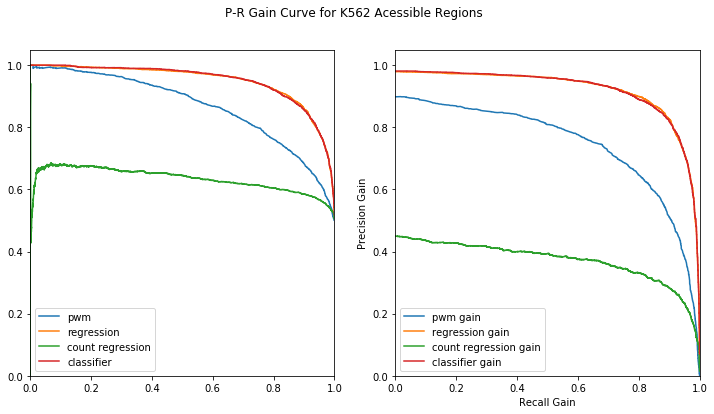

In [6]:
#make a lables list
labels = [c>0 for c in counts]
prop_pos = sum(labels)/len(labels)
print(prop_pos)

#make an aoc dict
aocs=dict()

#make a pr plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.set_ylim([0.0, 1.05])
ax2.set_ylim([0.0, 1.05])
ax1.set_xlim([0.0, 1.0])
ax2.set_xlim([0.0, 1.0])
plt.suptitle('P-R Gain Curve for CTCF Predictions on Holdout Set')
plt.suptitle('P-R Gain Curve for K562 Acessible Regions')
ax2.set_xlabel('Recall Gain')
ax2.set_ylabel('Precision Gain')
ax2.set_xlabel('Recall Gain')
ax2.set_ylabel('Precision Gain')

#graph on the plots
for key, pred_list in preds.items():    
    #get pr
    p, r, t = precision_recall_curve(labels, pred_list, pos_label=1)
    # get pr gain
    # mask out negative values and caluculate
    rindex, pindex = get_between(r, p)  
    pgain = [(x-prop_pos)/((1-prop_pos)*x) for x in p[rindex:pindex]]
    rgain = [(x-prop_pos)/((1-prop_pos)*x) for x in r[rindex:pindex]]
    # get aocs
    aocs[key]=pr_aoc(p, r)
    aocs[key+'_gain'] = pr_aoc(pgain,rgain)
    ax1.plot(r, p, label=key)
    ax2.plot(rgain, pgain, label= key +' gain')
        
ax2.legend()
ax1.legend()
plt.show()

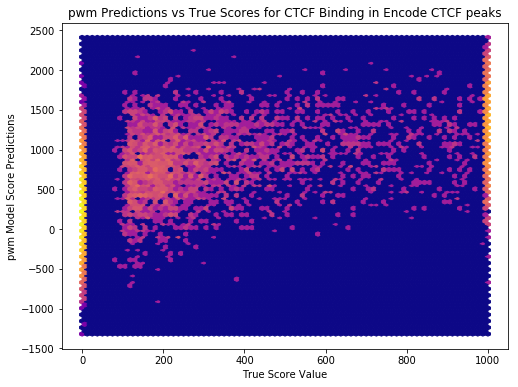

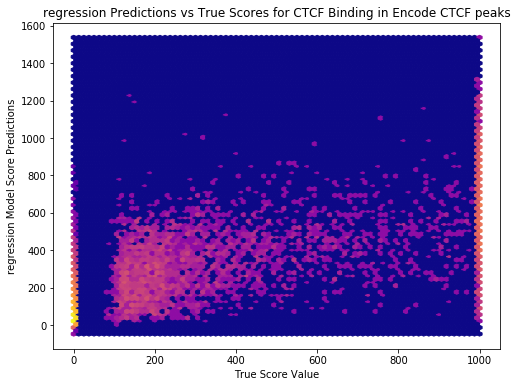

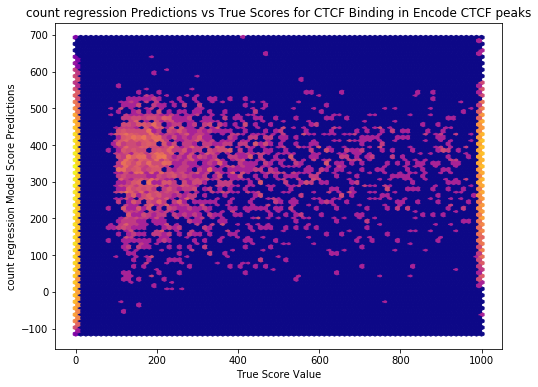

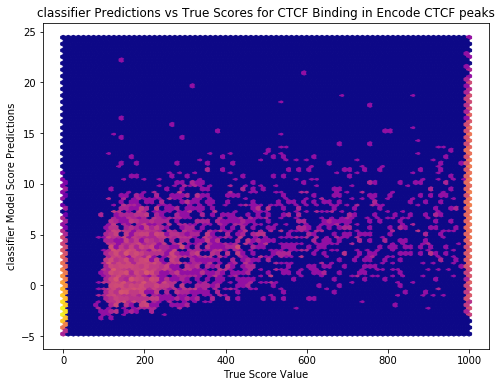

In [7]:
# make the heatmap of lore
for key, pred_list in preds.items():
    plt.figure(figsize=(8,6))
    plt.hexbin(counts, pred_list, bins='log', cmap='plasma', gridsize=80)
    plt.ylabel(key + ' Model Score Predictions')
    plt.xlabel('True Score Value')
    plt.title(key + ' Predictions vs True Scores for CTCF Binding in Encode CTCF peaks')
    plt.show()

In [8]:
# plot
plt.title('Distance-grouped prediction strength')
plt.xlabel('Distance from motif to mutation')
plt.ylabel('Predictive Power (AOPR-Gain Curve)')
plt.plot(128-mids, aoc, linestyle='-', marker='.', label='ML')
plt.plot(128-mids, pwm_aoc, linestyle='-', marker='.', label='PWM')
plt.legend()
plt.show()

NameError: name 'mids' is not defined

In [9]:
# predict on all atac sequences from k562 and make a p-r and p-r gain curve
bed_path = '/home/kal/TF_models/data/K562_atac_peaks/final_atac.bed'
peaks = pd.read_table(bed_path, header=None)
peaks.columns = 'chr start end ctcf_label . . '.split()
peaks = peaks[peaks['chr']!='chrM']

peaks = peaks.sample(1000)

# do the predictions
preds = dict()
#populate prediciton lists
for key, model in models.items():    
    preds[key] = model.predict_bed(peaks)

340it [00:05, 60.13it/s]


KeyboardInterrupt: 

In [ ]:
#make an aoc dict
aocs=dict()

#make a pr plot
prop_pos = sum(peaks['ctcf_label'])/len(peaks['ctcf_label'])

f, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))
ax1.set_ylim([0.0, 1.05])
ax2.set_ylim([0.0, 1.05])
ax1.set_xlim([0.0, 1.0])
ax2.set_xlim([0.0, 1.0])
plt.suptitle('P-R Gain Curve for K562 Acessible Regions')
ax2.set_xlabel('Recall Gain')
ax2.set_ylabel('Precision Gain')
ax2.set_xlabel('Recall Gain')
ax2.set_ylabel('Precision Gain')

#graph on the plots
for key, pred_list in preds.items():    
    #get pr
    p, r, t = precision_recall_curve(peaks['ctcf_label'], pred_list, pos_label=1)
    # get pr gain
    # mask out negative values and caluculate
    rindex, pindex = get_between(r, p)  
    pgain = [(x-prop_pos)/((1-prop_pos)*x) for x in p[rindex:pindex]]
    rgain = [(x-prop_pos)/((1-prop_pos)*x) for x in r[rindex:pindex]]
    # get aocs
    aocs[key]=pr_aoc(p, r)
    aocs[key+'_gain'] = pr_aoc(pgain,rgain)
    ax1.plot(r, p, label=key)
    ax2.plot(rgain, pgain, label= key +' gain')
        
ax2.legend()
ax1.legend()
plt.show()

In [ ]:
# make the heatmap of lore
for key, pred_list in preds.items():
    plt.figure(figsize=(8,6))
    plt.hexbin(pwm_preds, reg_preds, bins='log', cmap='plasma', gridsize=80)
    plt.xlabel('Position Weight Matrix Score Predictions')
    plt.ylabel('Regression Model Score Prediction')
    plt.title('DL vs PWM Predictions for CTCF Binding in Encode CTCF peaks')
    plt.show()

# make the heatmap of lore
plt.figure(figsize=(8,6))
plt.hexbin(pwm_preds, sig_preds, bins='log', cmap='plasma', gridsize=80)
plt.xlabel('Position Weight Matrix Score Predictions')
plt.ylabel('Classification Model Score Prediction')
plt.title('DL vs PWM Predictions for CTCF Binding in Encode CTCF peaks')
plt.show()

In [ ]:
# get the forth quadrant seqs
# get 4th quadrant seqs
intrigue = peaks[(peaks['pwm'] < 300)]
intrigue= intrigue[(intrigue['sig_ml'] > 7)]
intrigue = intrigue[(100*intrigue['sig_ml'] - intrigue['pwm'] > 100)]
#intrigue = intrigue.sample(200)
print(intrigue.shape)

plt.figure(figsize=(8,6))
plt.hexbin(intrigue['pwm'].tolist(), intrigue['sig_ml'].tolist(), bins='log', cmap='plasma', gridsize=50)
plt.xlabel('Position Weight Matrix Score Predictions')
plt.ylabel('Regression Model Score Prediction')
plt.title('DL vs PWM Predictions CTCF binding in K562 ATAC Regions')
plt.show()

In [ ]:
# write out the intereseting sequences in fasta format for further analysis
genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')
for index, row in intrigue.iterrows():   
    print('>'+ str(row.name) + '|' + str(row['sig_ml']) + '-' + str(row['pwm']))
    print(sequence.encode_to_string(row.seq))

In [ ]:
# predict on all atac sequences from k562 and make a p-r and p-r gain curve
bed_path = '/home/kal/TF_models/data/K562_atac_peaks/final_atac.bed'
peaks = pd.read_table(bed_path, header=None)
peaks.columns = 'chr start end ctcf_label . . '.split()
peaks = peaks[peaks['chr']!='chrM']
print(len(peaks))

In [ ]:
pwm_preds = pwm.predict_bed(peaks)
peaks['pwm'] = pwm_preds
reg_preds = reg.predict_bed(peaks)
peaks['reg_ml'] = reg_preds
sig_preds = sig.predict_bed(peaks)
peaks['sig_ml'] = sig_preds
true_labels = peaks['ctcf_label']

In [ ]:
header = ['chr', 'start', 'end', 'ctcf_label', 'pwm', 'reg_ml', 'sig_ml']
peaks.to_csv('/home/kal/TF_models/data/encode_ctcf_annotated.bed', sep='\t', columns = header)

In [ ]:
# load the model
peaks = pd.read_table('/home/kal/TF_models/data/encode_ctcf_annotated.bed')
columns = ['chr', 'start', 'end', 'ctcf_label', 'pwm', 'reg_ml', 'sig_ml']
true_labels = peaks['ctcf_label']

In [ ]:
#p-r curve
sig_p, sig_r, sig_t = precision_recall_curve(peaks['ctcf_label'], peaks['sig_ml'], pos_label=1)
pwm_p, pwm_r, pwm_t = precision_recall_curve(peaks['ctcf_label'], peaks['pwm'], pos_label=1)
reg_p, reg_r, reg_t = precision_recall_curve(peaks['ctcf_label'], peaks['reg_ml'], pos_label=1)

plt.figure(figsize=(8,6))
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('P-R Curve for CTCF Binding in K562 ATAC Regions')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(sig_r, sig_p, label='Classification Model')
plt.plot(reg_r, reg_p, label='Regression Model')
plt.plot(pwm_r, pwm_p, label='PWM Model')
plt.legend()
plt.show()

In [ ]:
#p-r gain gurve
# we consider only p/r value between prop_pos and 1
prop_pos = sum(true_labels)/len(true_labels)

sig_pgain = [(x-prop_pos)/((1-prop_pos)*x) for x in sig_p]
sig_rgain = [(x-prop_pos)/((1-prop_pos)*x) for x in sig_r]
reg_pgain = [(x-prop_pos)/((1-prop_pos)*x) for x in reg_p]
reg_rgain = [(x-prop_pos)/((1-prop_pos)*x) for x in reg_r]
pwm_pgain = [(x-prop_pos)/((1-prop_pos)*x) for x in pwm_p]
pwm_rgain = [(x-prop_pos)/((1-prop_pos)*x) for x in pwm_r]

plt.figure(figsize=(8,6))
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('P-R Gain Curve for CTCF Binding in K562 ATAC Regions')
plt.xlabel('Recall Gain')
plt.ylabel('Precision Gain')
plt.plot(sig_pgain, sig_rgain, label='Classification Model')
plt.plot(reg_rgain, reg_pgain, label='Regression Model')
plt.plot(pwm_rgain, pwm_pgain, label='PWM Model')
plt.legend()
plt.show()

In [ ]:
# make the heatmap of lore
plt.figure(figsize=(8,6))
plt.hexbin(peaks['pwm'], peaks['reg_ml'], bins='log', cmap='plasma', gridsize=100)
plt.xlabel('Position Weight Matrix Score Predictions')
plt.ylabel('Regression Model Score Prediction')
plt.title('DL vs PWM Predictions CTCF binding in K562 ATAC Regions')
plt.show()

# make the heatmap of lore
plt.figure(figsize=(8,6))
plt.hexbin(peaks['pwm'], peaks['sig_ml'], bins='log', cmap='plasma', gridsize=100)
plt.xlabel('Position Weight Matrix Score Predictions')
plt.ylabel('Classification Model Score Prediction')
plt.title('DL vs PWM Predictions CTCF binding in K562 ATAC Regions')
plt.show()

In [ ]:
# get 4th quadrant seqs
intrigue= peaks[(peaks['ctcf_label'])]
intrigue= intrigue[(intrigue['pwm'] < 1200)]
intrigue= intrigue[(intrigue['reg_ml'] > 900)]
print(intrigue.shape)

plt.figure(figsize=(8,6))
plt.hexbin(intrigue['pwm'].tolist(), intrigue['reg_ml'].tolist(), bins='log', cmap='plasma', gridsize=100)
plt.xlabel('Position Weight Matrix Score Predictions')
plt.ylabel('Regression Model Score Prediction')
plt.title('DL vs PWM Predictions CTCF binding in K562 ATAC Regions')
plt.show()

In [ ]:
# write out the intereseting sequences in fasta format for further analysis
genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')
with open('/home/kal/TF_models/data/K562_atac_peaks/2nd_quad_seqs.fa', 'w') as output:
    output.write('>prediction_ml|predictions_pwm\nsequence\n')
    for index, row in intrigue.iterrows():
        seq = reg.localize(row, genome)[0]
        output.write('>'+ str(row.name) + '|' + str(row['reg_ml']) + '-' + str(row['pwm']) + '\n')
        output.write(sequence.encode_to_string(seq.seq))

        print('>'+ str(row.name) + '|' + str(row['reg_ml']) + '-' + str(row['pwm']))
        print(sequence.encode_to_string(seq.seq))

In [ ]:
# get some normal seqs
intrigue = peaks[(peaks['ctcf_label'])]
intrigue = intrigue[(intrigue['reg_ml'] < 800)]
intrigue = intrigue[(intrigue['pwm'] > 1700)]
print(intrigue.shape)
intrigue = intrigue.sample(250)

plt.figure(figsize=(8,6))
plt.hexbin(intrigue['pwm'].tolist(), intrigue['reg_ml'].tolist(), bins='log', cmap='plasma', gridsize=100)
plt.xlabel('Position Weight Matrix Score Predictions')
plt.ylabel('Regression Model Score Prediction')
plt.title('DL vs PWM Predictions CTCF binding in K562 ATAC Regions')
plt.show()

In [ ]:
# write out the intereseting sequences in fasta format for further analysis
genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')
with open('/home/kal/TF_models/data/K562_atac_peaks/background_seqs.fa', 'w') as output:
    output.write('>prediction_ml|predictions_pwm\nsequence\n')
    for index, row in intrigue.iterrows():
        seq = reg.localize(row, genome)[0]
        output.write('>'+ str(row.name) + '|' + str(row['reg_ml']) + '-' + str(row['pwm']) + '\n')
        output.write(sequence.encode_to_string(seq.seq))

        print('>'+ str(row.name) + '|' + str(row['reg_ml']) + '-' + str(row['pwm']))
        print(sequence.encode_to_string(seq.seq))

In [ ]:
plt.hist(peaks['reg_ml'], bins=100)
plt.show()

In [ ]:
bed_path = '/home/kal/TF_models/data/encode_chipseq_peaks.bed'
gen_path = '/home/kal/TF_models/bin/test_gen.hdf5'
TF='CTCF'
seq_only_gen.create_from_bed(bed_path, gen_path, TF=TF, example_limit = 25000)        
gen = seq_only_gen.TFGenerator(gen_path)

In [ ]:
n = gen.neg_gen()
print(next(n))